In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import tensorflow_datasets as tfds
from tensorflow.keras.datasets import fashion_mnist

from PIL import Image, ImageFont, ImageDraw
import random

from tqdm import tqdm
import matplotlib.ticker as mticker

# Define Identity Block and ResNet model

In [2]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

In [3]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

# Load and preprocess training and testing datasets

In [22]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='../data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='../data/', download=True)

In [23]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [24]:
train_data.element_spec

{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [25]:
def format_image(data):        
    image = data["image"]
    label = data['label']
#     image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return {'image':image,'label':label}

In [26]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [27]:
train_data.element_spec

{'image': TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [42]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

# Define Optimizer and Loss Function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Define Metrics

In [29]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Build Training Loop

In [31]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))
    
    return logits, loss_value

In [32]:
def train_data_for_one_epoch():
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    
    for step, batch in enumerate(train):        
        
        x_batch_train = batch['image']
        y_batch_train = batch['label']
        
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        
        losses.append(loss_value)
      
        train_acc_metric(y_batch_train, logits)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
        
    return losses    

In [45]:
def perform_validation():
    losses = []
    for batch in test:
        
        x_val = batch['image']
        y_val = batch['label']
        
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

In [46]:
model = ResNet(10)

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()
    
    
    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.4647: 100%|█████████████████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 0: Train loss: 0.6501  Validation Loss: 0.4707, Train Accuracy: 0.7418, Validation Accuracy 0.8327
Start of epoch 1


Training loss for step 937: 0.4616: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 



 Epoch 1: Train loss: 0.3904  Validation Loss: 0.3771, Train Accuracy: 0.8582, Validation Accuracy 0.8628
Start of epoch 2


Training loss for step 937: 0.5012: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 


 Epoch 2: Train loss: 0.3280  Validation Loss: 0.3535, Train Accuracy: 0.8781, Validation Accuracy 0.8739
Start of epoch 3



Training loss for step 937: 0.2436: 100%|█████████████████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 3: Train loss: 0.3016  Validation Loss: 0.3300, Train Accuracy: 0.8888, Validation Accuracy 0.8793
Start of epoch 4


Training loss for step 937: 0.2436: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.5123: 100%|█████████████████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 4: Train loss: 0.2822  Validation Loss: 0.3044, Train Accuracy: 0.8963, Validation Accuracy 0.8919
Start of epoch 5


Training loss for step 937: 0.4973: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.4647: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.5123: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2433: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 


 Epoch 5: Train loss: 0.2647  Validation Loss: 0.2941, Train Accuracy: 0.9014, Validation Accuracy 0.8938
Start of epoch 6


Training loss for step 937: 0.1029: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 



 Epoch 6: Train loss: 0.2484  Validation Loss: 0.2903, Train Accuracy: 0.9079, Validation Accuracy 0.8966
Start of epoch 7


Training loss for step 937: 0.1035: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 


 Epoch 7: Train loss: 0.2390  Validation Loss: 0.2873, Train Accuracy: 0.9116, Validation Accuracy 0.8963
Start of epoch 8



Training loss for step 937: 0.2228: 100%|█████████████████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 8: Train loss: 0.2275  Validation Loss: 0.2822, Train Accuracy: 0.9151, Validation Accuracy 0.8987
Start of epoch 9


Training loss for step 937: 0.2228: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.0998: 100%|█████████████████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 9: Train loss: 0.2171  Validation Loss: 0.2997, Train Accuracy: 0.9196, Validation Accuracy 0.8976


Training loss for step 937: 0.0998: 100%|██████████████████████████████████████████████████████████████████████████████| 938/938 

# Evaluate the Model

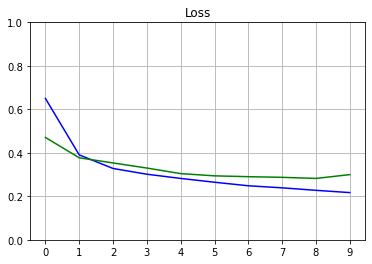

In [48]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.grid()

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [50]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n, 28, 28])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)

In [54]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for batch in test_inputs:
    
    x = batch['image']
    y = batch['label']
    
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()

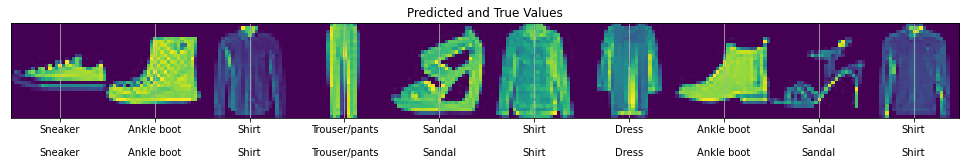

In [57]:
indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

In [58]:
model.summary()

Model: "res_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           multiple                  3200      
_________________________________________________________________
batch_normalization_15 (Batc multiple                  256       
_________________________________________________________________
activation_9 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
identity_block_6 (IdentityBl multiple                  74368     
_________________________________________________________________
identity_block_7 (IdentityBl multiple                  74368     
_________________________________________________________________
global_average_pooling2d_3 ( multiple                  0 

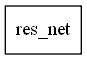

In [5]:
plot_model(resnet,
           to_file='model.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=True,
           dpi=96,
          )